# Semantic Segmentation


Датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>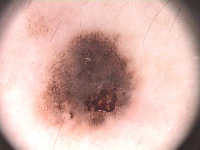</td><td>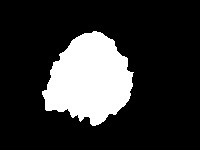</td></tr></table>

Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [ ]:
! wget https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar

--2021-05-16 20:59:08--  https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4q6kwg8de56eqnc/PH2Dataset.rar [following]
--2021-05-16 20:59:08--  https://www.dropbox.com/s/raw/4q6kwg8de56eqnc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccfff67660cb89e0e52dada506b.dl.dropboxusercontent.com/cd/0/inline/BOkH_wOYqZFuzfTBkXc-g8UtAzJfy8wTogsUx6-1fTxLZ71pUyUZUCpf7TnHdIVmtrVyY4cPXD7XA1ElVY0vjf7I4LoajSrpJTs8ny2F1ZTpiKinQkdUQwyFjiFd3Af6LQy4yRCOiS4fs30noy_2IZlV/file# [following]
--2021-05-16 20:59:08--  https://uccfff67660cb89e0e52dada506b.dl.dropboxusercontent.com/cd/0/inline/BOkH_wOYqZFuzfTBkXc-g8UtAzJfy8wTogsUx6-1fTxLZ71pUyUZUCpf7TnHdIVmtrVyY4cPXD7XA1ElVY0v

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю используем skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
import torch
import numpy as np
from numpy import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры, изменим их размер на $256\times256 $ пикселей.



In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

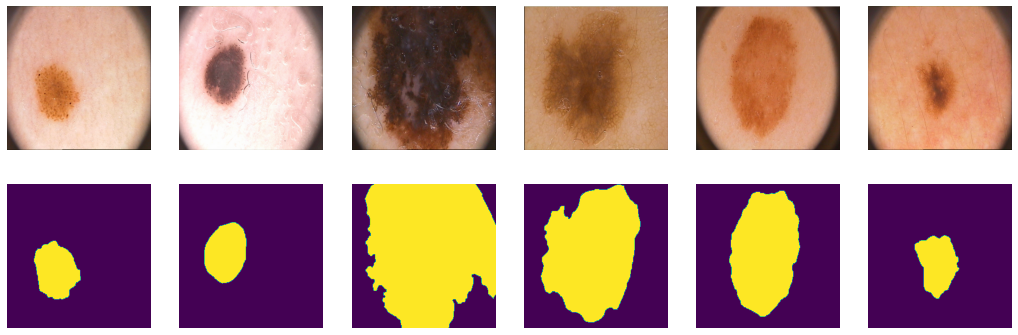

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))
print(tr[0])

100 50 50
95


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:


-----------------------------------------------------------------------------------------

# SegNet [2 балла]

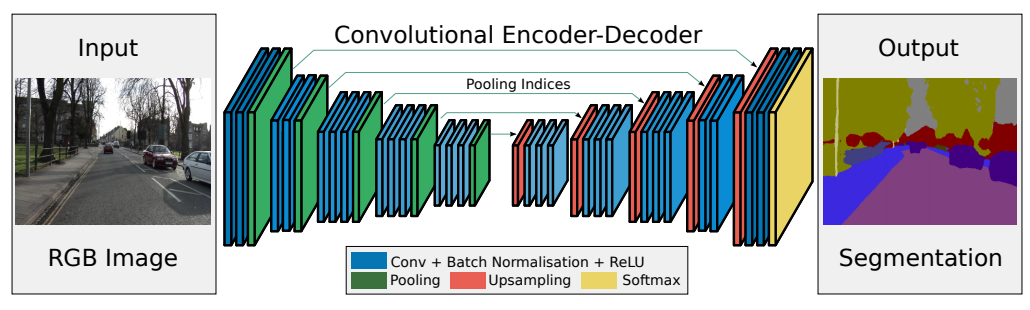

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 16, (3,3), padding=1)
        self.pool0 = nn.MaxPool2d(2)
        self.enc_conv1 = nn.Conv2d(16, 32, (3,3), padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc_conv2 = nn.Conv2d(32, 64, (3,3), padding=1)
        self.pool2 =  nn.MaxPool2d(2)
        self.enc_conv3 = nn.Conv2d(64, 128, (3,3), padding=1)
        self.pool3 =  nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(128, 128, (3,3), padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(32)
        self.dec_conv0 = nn.Conv2d(128, 64, (3,3), padding=1)
        self.upsample1 = nn.UpsamplingBilinear2d(64)
        self.dec_conv1 = nn.Conv2d(64, 32, (3,3), padding=1)
        self.upsample2 = nn.UpsamplingBilinear2d(128)
        self.dec_conv2 = nn.Conv2d(32, 16, (3,3), padding=1)
        self.upsample3 = nn.UpsamplingBilinear2d(256)
        self.dec_conv3 = nn.Conv2d(16, 1, (3,3), padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(e3)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
import math
def bce_loss(y_real, y_pred):
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    losses = []
    metrics = []
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model.forward(X_batch)
            loss =  loss_fn(Y_batch, Y_pred.to(device))
            loss.backward()  # backward-pass
            opt.step()  # update weights
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model.forward(X_val.to(device)).to(torch.device('cpu:0')).detach().numpy() # detach and put into cpu
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        metrics.append(iou_pytorch(torch.FloatTensor(Y_hat) > 0.5, torch.FloatTensor(Y_val)).mean().item())
        losses.append(loss_fn(Y_val, torch.FloatTensor(Y_hat)))
    return losses, metrics

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred > 0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    ax = tuple(range(1, len(y_pred.shape)-1))
    num = 2. * torch.sum(y_real * y_pred, ax)
    den =  torch.sum(torch.square(y_real) + torch.square(y_pred), ax)
    res = 1 - torch.mean(num / (den))
    return res

Проводим тестирование:

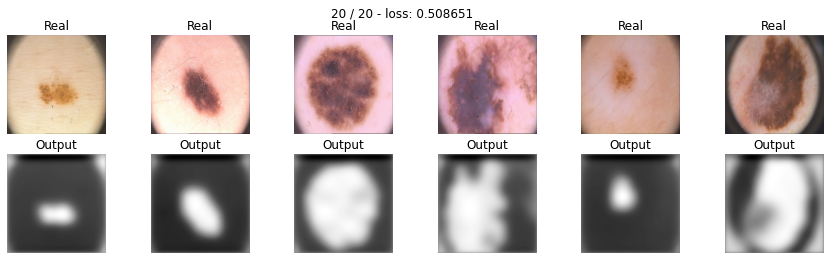

0.4179999828338623

In [ ]:
model_dice = SegNet().to(device)
max_epochs = 20
optimaizer = optim.Adam(model_dice.parameters())
seg_dice_losses, seg_dice_metrics = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)
seg_dice_score = score_model(model_dice, iou_pytorch, data_ts)
seg_dice_score

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    #y_pred = torch.sigmoid(y_pred)
    loss = (y_real) * (1 - torch.sigmoid(y_pred))**gamma * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.sigmoid(y_pred)**gamma * torch.log(1 - torch.sigmoid(y_pred))
    return torch.mean(-loss)

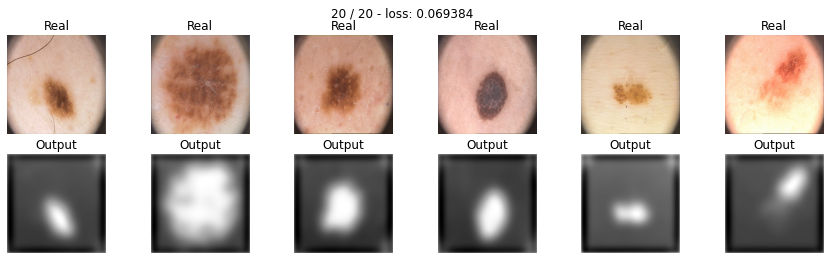

0.24800001829862595

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer = optim.Adam(model_focal.parameters())
seg_focal_losses, seg_focal_metrics = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)
seg_focal_score = score_model(model_focal, iou_pytorch, data_ts)
seg_focal_score

## Основной момент: обучение

In [ ]:
seg_model = SegNet().to(device)

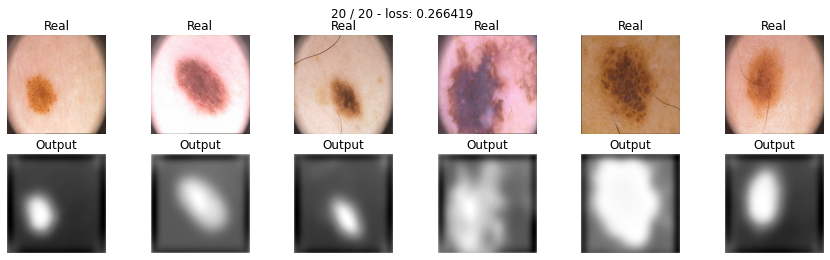

0.42000000178813934

In [ ]:
max_epochs = 20
optimizer = optim.Adam(seg_model.parameters())
seg_bce_losses, seg_bce_metrics = train(seg_model, optimizer, bce_loss, max_epochs, data_tr, data_val)
seg_bce_score = score_model(seg_model, iou_pytorch, data_ts)
seg_bce_score

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [ ]:
def tversky_loss(y_true, y_pred):
    y_true_pos = torch.flatten(y_true)
    y_pred_pos = torch.flatten(torch.sigmoid(y_pred))
    true_pos = torch.sum(y_true_pos * y_pred_pos)
    false_neg = torch.sum(y_true_pos * (1-y_pred_pos))
    false_pos = torch.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.85
    smooth = 1e-8
    return 1 - (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

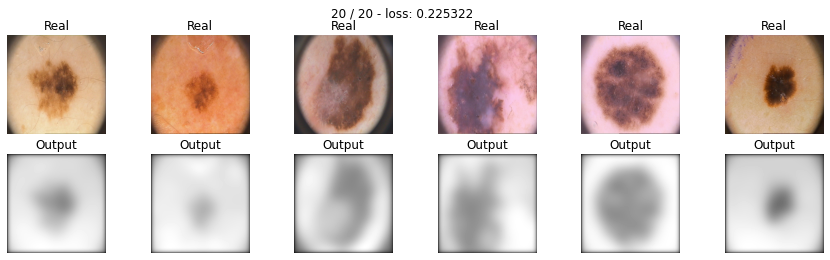

0.0560000017285347

In [ ]:
seg_model = SegNet().to(device)
max_epochs = 20
optimizer = optim.Adam(seg_model.parameters())
seg_tversky_losses, seg_tversky_metrics = train(seg_model, optimizer, tversky_loss, max_epochs, data_tr, data_val)
seg_tversky_score = score_model(seg_model, iou_pytorch, data_ts)
seg_tversky_score

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

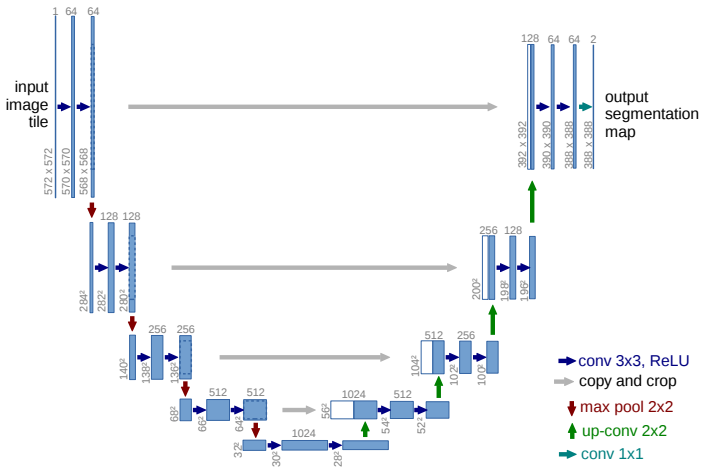

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, (3,3), padding=1)
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(32, 64, (3,3), padding=1)
        self.pool1 = nn.MaxPool2d(2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 128, (3,3), padding=1)
        self.pool2 =  nn.MaxPool2d(2) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(128, 256, (3,3), padding=1)
        self.pool3 =  nn.MaxPool2d(2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, (3,3), padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(32) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(512, 128, (3,3), padding=1)
        self.upsample1 = nn.UpsamplingBilinear2d(64) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(256, 64, (3,3), padding=1)
        self.upsample2 = nn.UpsamplingBilinear2d(128) # 64 -> 128
        self.dec_conv2 = nn.Conv2d(128, 32, (3,3), padding=1)
        self.upsample3 = nn.UpsamplingBilinear2d(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 1, (3,3), padding=1)

    def forward(self, x):
        # encoder
        c0 = F.relu(self.enc_conv0(x))
        e0 = self.pool0(c0)
        c1 = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(c1)
        c2 = F.relu(self.enc_conv2(e1))
        e2 = self.pool2(c2)
        c3 = F.relu(self.enc_conv3(e2))
        e3 = self.pool3(c3)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat((self.upsample0(b), c3), dim = 1)))
        d1 = F.relu(self.dec_conv1(torch.cat((self.upsample1(d0), c2), dim = 1)))
        d2 = F.relu(self.dec_conv2(torch.cat((self.upsample2(d1), c1), dim = 1)))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), c0), dim = 1)) # no activation
        return d3

In [ ]:
from torchsummary import summary # чтобы смотреть описание мордели и ее параметров как в keras

model = UNet().to(device)
#summary(model, input_size=(3, 256, 256), device=device.type)

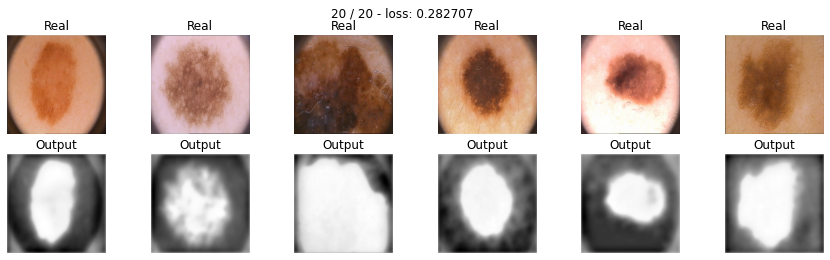

0.44200000166893005

In [ ]:
unet_model = UNet().to(device)
unet_bce_losses, unet_bce_metrics = train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)
unet_bce_score = score_model(unet_model, iou_pytorch, data_ts)
unet_bce_score

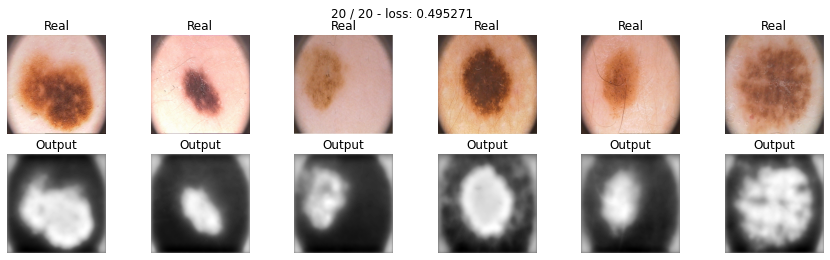

0.2799999862909317

In [ ]:
unet_model = UNet().to(device)
unet_dice_losses, unet_dice_metrics = train(unet_model, optim.Adam(unet_model.parameters()), dice_loss, 20, data_tr, data_val)
unet_dice_score = score_model(unet_model, iou_pytorch, data_ts)
unet_dice_score

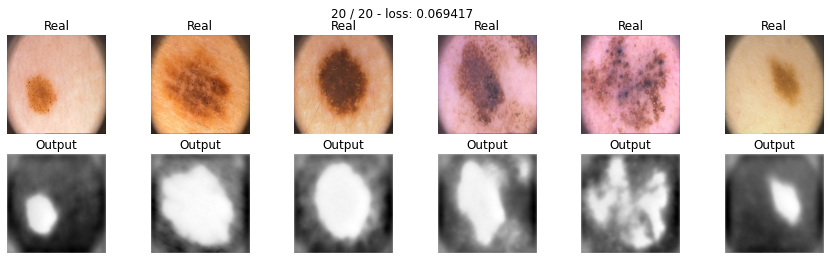

0.5399999916553497

In [ ]:
unet_model = UNet().to(device)
unet_focal_losses, unet_focal_metrics = train(unet_model, optim.Adam(unet_model.parameters()), focal_loss, 20, data_tr, data_val)
unet_focal_score = score_model(unet_model, iou_pytorch, data_ts)
unet_focal_score

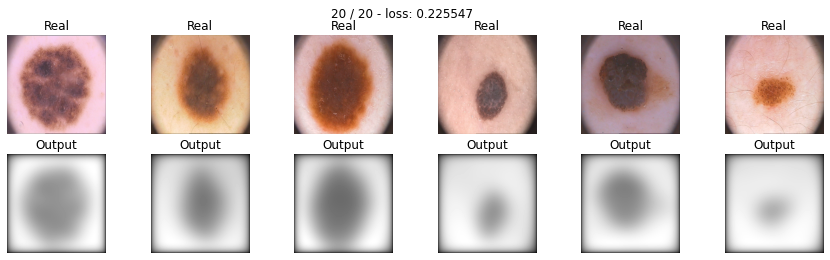

0.05600000265985727

In [ ]:
unet_model = UNet().to(device)
unet_tversky_losses, unet_tversky_metrics = train(unet_model, optim.Adam(unet_model.parameters()), tversky_loss, 20, data_tr, data_val)
unet_tversky_score = score_model(unet_model, iou_pytorch, data_ts)
unet_tversky_score

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, (3,3), padding=1)
        self.pool0 = nn.Conv2d(32, 32, (2,2), stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(32, 64, (3,3), padding=1)
        self.pool1 = nn.Conv2d(64, 64, (2,2), stride=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 128, (3,3), padding=1)
        self.pool2 =  nn.Conv2d(128, 128, (2,2), stride=2) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(128, 256, (3,3), padding=1)
        self.pool3 =  nn.Conv2d(256, 256, (2,2), stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, (3,3), padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256, 256, (2,2), stride=2) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(512, 128, (3,3), padding=1)
        self.upsample1 = nn.ConvTranspose2d(128, 128, (2,2), stride=2) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(256, 64, (3,3), padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 64, (2,2), stride=2) # 64 -> 128
        self.dec_conv2 = nn.Conv2d(128, 32, (3,3), padding=1)
        self.upsample3 = nn.ConvTranspose2d(32, 32, (2,2), stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 1, (3,3), padding=1)

    def forward(self, x):
        # encoder
        c0 = F.relu(self.enc_conv0(x))
        e0 = self.pool0(c0)
        c1 = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(c1)
        c2 = F.relu(self.enc_conv2(e1))
        e2 = self.pool2(c2)
        c3 = F.relu(self.enc_conv3(e2))
        e3 = self.pool3(c3)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))
        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat((self.upsample0(b), c3), dim = 1)))
        d1 = F.relu(self.dec_conv1(torch.cat((self.upsample1(d0), c2), dim = 1)))
        d2 = F.relu(self.dec_conv2(torch.cat((self.upsample2(d1), c1), dim = 1)))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), c0), dim = 1)) # no activation
        return d3

In [ ]:
from torchsummary import summary # чтобы смотреть описание мордели и ее параметров как в keras

model = UNet2().to(device)
#summary(model, input_size=(3, 256, 256), device=device.type)

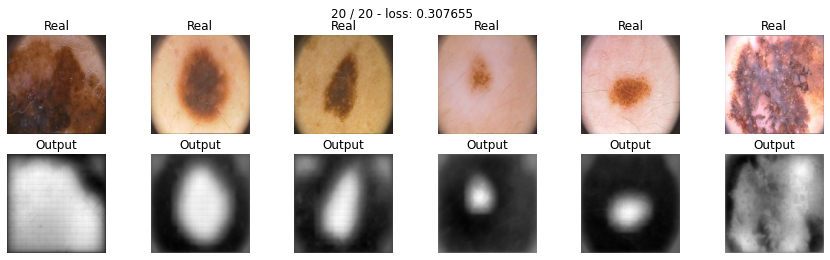

0.4259999990463257

In [ ]:
unet2_model = UNet2().to(device)
unet2_bce_losses, unet2_bce_metrics = train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 20, data_tr, data_val)
unet2_bce_score = score_model(unet2_model, iou_pytorch, data_ts)
unet2_bce_score

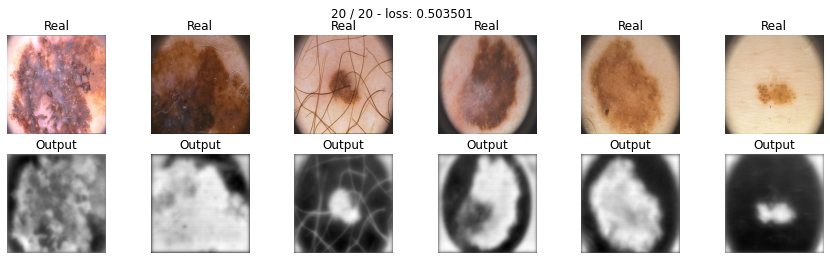

0.2499999925494194

In [ ]:
unet2_model = UNet2().to(device)
unet2_dice_losses, unet2_dice_metrics = train(unet2_model, optim.Adam(unet2_model.parameters()), dice_loss, 20, data_tr, data_val)
unet2_dice_score = score_model(unet2_model, iou_pytorch, data_ts)
unet2_dice_score

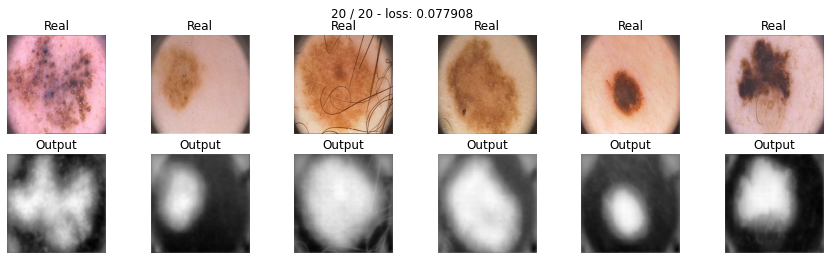

0.32600000500679016

In [ ]:
unet2_model = UNet2().to(device)
unet2_focal_losses, unet2_focal_metrics = train(unet2_model, optim.Adam(unet2_model.parameters()), focal_loss, 20, data_tr, data_val)
unet2_focal_score = score_model(unet2_model, iou_pytorch, data_ts)
unet2_focal_score

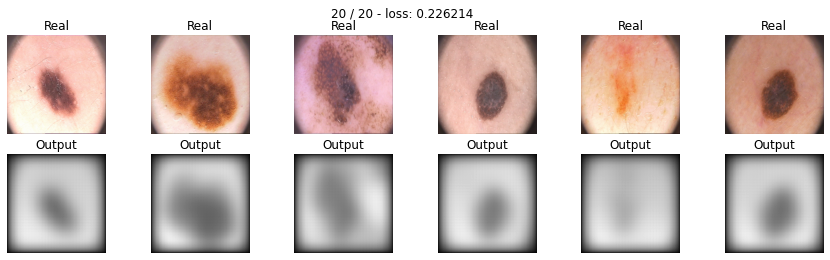

0.055999997071921825

In [ ]:
unet2_model = UNet2().to(device)
unet2_tversky_losses, unet2_tversky_metrics = train(unet2_model, optim.Adam(unet2_model.parameters()), tversky_loss, 20, data_tr, data_val)
unet2_tversky_score = score_model(unet2_model, iou_pytorch, data_ts)
unet2_tversky_score

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [ ]:
class DilatedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, (3,3), padding=1)
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(32, 64, (3,3), padding=1)
        self.pool1 = nn.MaxPool2d(2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 128, (3,3), padding=1)
        self.pool2 =  nn.MaxPool2d(2) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(128, 256, (3,3), padding=1)
        self.pool3 =  nn.MaxPool2d(2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv0 = nn.Conv2d(256, 256, (3,3), padding=1, dilation=1)
        self.bottleneck_conv1 = nn.Conv2d(256, 256, (3,3), padding=2, dilation=2)
        self.bottleneck_conv2 = nn.Conv2d(256, 256, (3,3), padding=4, dilation=4)
        self.bottleneck_conv3 = nn.Conv2d(256, 256, (3,3), padding=8, dilation=8)
        self.bottleneck_conv4 = nn.Conv2d(256, 256, (3,3), padding=16, dilation=16)
        self.bottleneck_conv5 = nn.Conv2d(256, 256, (3,3), padding=32, dilation=32)
  
        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(32) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(512, 128, (3,3), padding=1)
        self.upsample1 = nn.UpsamplingBilinear2d(64) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(256, 64, (3,3), padding=1)
        self.upsample2 = nn.UpsamplingBilinear2d(128) # 64 -> 128
        self.dec_conv2 = nn.Conv2d(128, 32, (3,3), padding=1)
        self.upsample3 = nn.UpsamplingBilinear2d(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 1, (3,3), padding=1)

    def forward(self, x):
        # encoder
        c0 = F.relu(self.enc_conv0(x))
        e0 = self.pool0(c0)
        c1 = F.relu(self.enc_conv1(e0))
        e1 = self.pool1(c1)
        c2 = F.relu(self.enc_conv2(e1))
        e2 = self.pool2(c2)
        c3 = F.relu(self.enc_conv3(e2))
        e3 = self.pool3(c3)

        # bottleneck
        b0 = self.bottleneck_conv0(e3)
        b1 = self.bottleneck_conv1(b0)
        b2 = self.bottleneck_conv2(b1)
        b3 = self.bottleneck_conv3(b2)
        b4 = self.bottleneck_conv4(b3)
        b5 = self.bottleneck_conv5(b4)
        b = F.relu(b0 + b1 + b2 + b3 + b4 + b5)
        # decoder

        d0 = F.relu(self.dec_conv0(torch.cat((self.upsample0(b), c3), dim = 1)))
        d1 = F.relu(self.dec_conv1(torch.cat((self.upsample1(d0), c2), dim = 1)))
        d2 = F.relu(self.dec_conv2(torch.cat((self.upsample2(d1), c1), dim = 1)))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), c0), dim = 1)) # no activation
        return d3

In [ ]:
from torchsummary import summary # чтобы смотреть описание мордели и ее параметров как в keras

model = DilatedUNet().to(device)
#summary(model, input_size=(3, 256, 256), device=device.type)

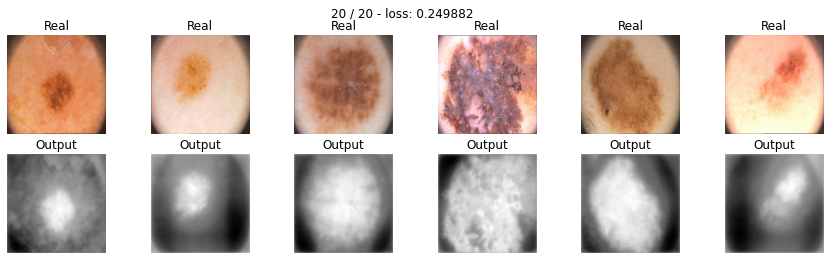

0.5160000026226044

In [ ]:
dilated_model = DilatedUNet().to(device)
dilated_bce_losses, dilated_bce_metrics = train(dilated_model, optim.Adam(dilated_model.parameters()), bce_loss, 20, data_tr, data_val)
dilated_bce_score = score_model(dilated_model, iou_pytorch, data_ts)
dilated_bce_score

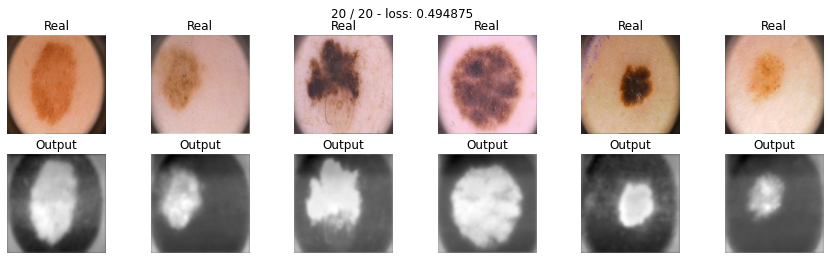

0.3920000046491623

In [ ]:
dilated_model = DilatedUNet().to(device)
dilated_dice_losses, dilated_dice_metrics = train(dilated_model, optim.Adam(dilated_model.parameters()), dice_loss, 20, data_tr, data_val)
dilated_dice_score = score_model(dilated_model, iou_pytorch, data_ts)
dilated_dice_score

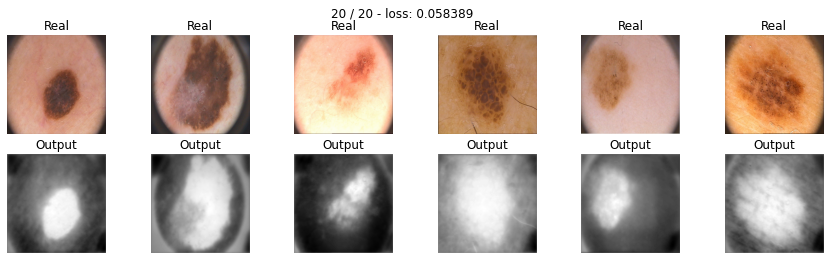

0.6279999911785126

In [ ]:
dilated_model = DilatedUNet().to(device)
dilated_focal_losses, dilated_focal_metrics = train(dilated_model, optim.Adam(dilated_model.parameters()), focal_loss, 20, data_tr, data_val)
dilated_focal_score = score_model(dilated_model, iou_pytorch, data_ts)
dilated_focal_score

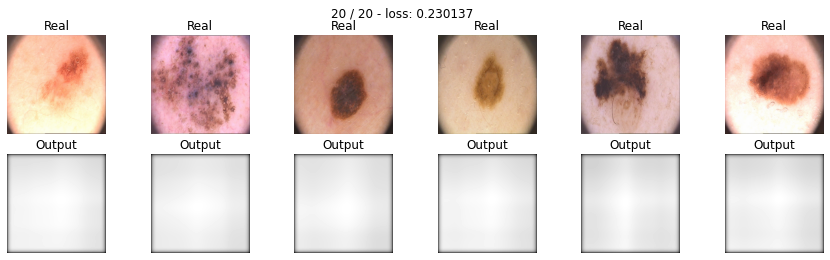

0.05599999986588955

In [ ]:
dilated_model = DilatedUNet().to(device)
dilated_tversky_losses, dilated_tversky_metrics = train(dilated_model, optim.Adam(dilated_model.parameters()), tversky_loss, 20, data_tr, data_val)
dilated_tversky_score = score_model(dilated_model, iou_pytorch, data_ts)
dilated_tversky_score

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



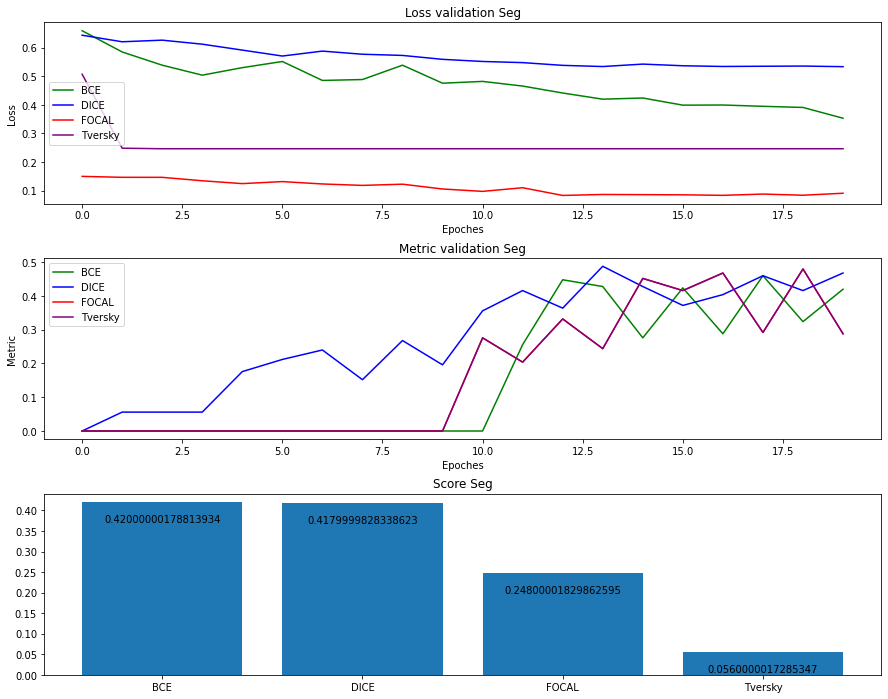

In [ ]:
scores = [seg_bce_score, seg_dice_score, seg_focal_score, seg_tversky_score]
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
plt.subplot(3, 1, 1)
plt.title('Loss validation Seg')
plt.ylabel('Loss')
plt.xlabel('Epoches')
plt.plot(torch.FloatTensor(seg_bce_losses), color = "green", label='BCE')
plt.plot(torch.FloatTensor(seg_dice_losses), color = "blue", label='DICE')
plt.plot(torch.FloatTensor(seg_focal_losses), color = "red", label='FOCAL')
plt.plot(torch.FloatTensor(seg_tversky_losses), color = "purple", label='Tversky')
plt.legend()
plt.subplot(3, 1, 2)
plt.title('Metric validation Seg')
plt.ylabel('Metric')
plt.xlabel('Epoches')
plt.plot(torch.FloatTensor(seg_bce_metrics), color = "green", label='BCE')
plt.plot(torch.FloatTensor(seg_dice_metrics), color = "blue", label='DICE')
plt.plot(torch.FloatTensor(seg_focal_metrics), color = "red", label='FOCAL')
plt.plot(torch.FloatTensor(seg_focal_metrics), color = "purple", label='Tversky')
plt.legend()
plt.subplot(3, 1, 3)
plt.title("Score Seg")
plt.bar(['BCE', 'DICE', 'FOCAL', 'Tversky'], scores)
plt.subplots_adjust(wspace=10, hspace=0.3)
for i in range(4):
  plt.text(i, scores[i]-0.05, str(scores[i]), ha='center')

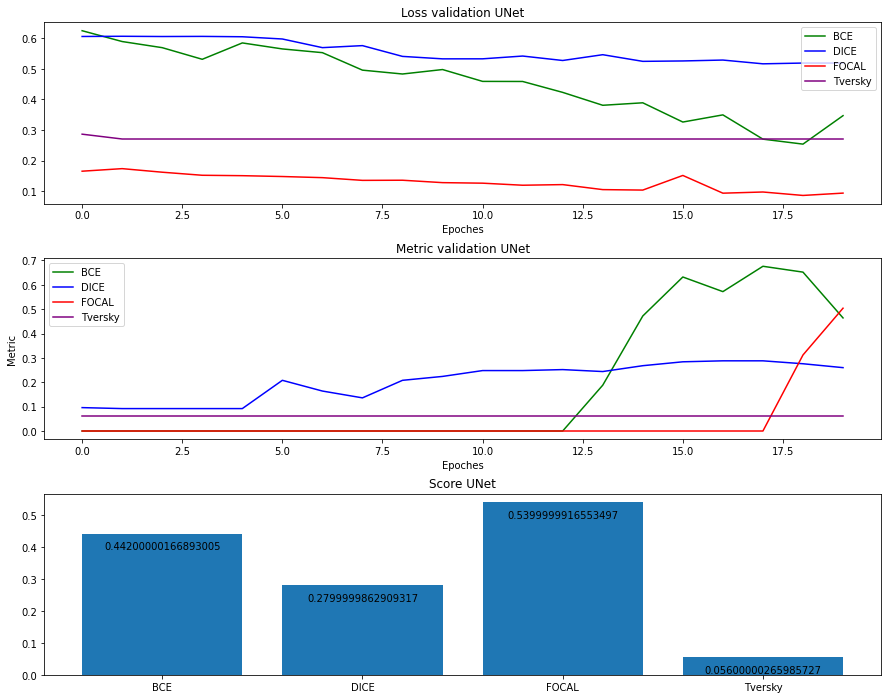

In [ ]:
scores = [unet_bce_score, unet_dice_score, unet_focal_score, unet_tversky_score]
plt.subplot(3, 1, 1)
plt.title('Loss validation UNet')
plt.ylabel('Loss', color="white")
plt.xlabel('Epoches')
plt.plot(torch.FloatTensor(unet_bce_losses), color = "green", label='BCE')
plt.plot(torch.FloatTensor(unet_dice_losses), color = "blue", label='DICE')
plt.plot(torch.FloatTensor(unet_focal_losses), color = "red", label='FOCAL')
plt.plot(torch.FloatTensor(unet_tversky_losses), color = "purple", label='Tversky')
plt.legend()
plt.subplot(3, 1, 2)
plt.title('Metric validation UNet')
plt.ylabel('Metric')
plt.xlabel('Epoches')
plt.plot(torch.FloatTensor(unet_bce_metrics), color = "green", label='BCE')
plt.plot(torch.FloatTensor(unet_dice_metrics), color = "blue", label='DICE')
plt.plot(torch.FloatTensor(unet_focal_metrics), color = "red", label='FOCAL')
plt.plot(torch.FloatTensor(unet_tversky_metrics), color = "purple", label='Tversky')
plt.legend()
plt.subplot(3, 1, 3)
plt.bar(['BCE', 'DICE', 'FOCAL', 'Tversky'], scores)
plt.title("Score UNet")
plt.subplots_adjust(wspace=10, hspace=0.3)
for i in range(4):
  plt.text(i, scores[i]-0.05, str(scores[i]), ha='center')

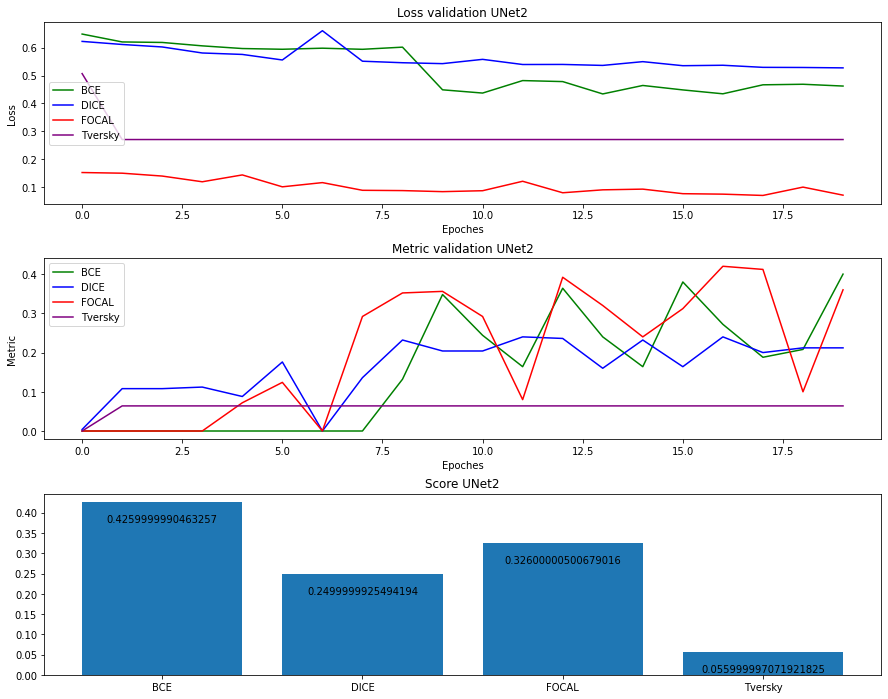

In [ ]:
scores = [unet2_bce_score, unet2_dice_score, unet2_focal_score, unet2_tversky_score]
plt.subplot(3, 1, 1)
plt.title('Loss validation UNet2')
plt.ylabel('Loss')
plt.xlabel('Epoches')
plt.plot(torch.FloatTensor(unet2_bce_losses), color = "green", label='BCE')
plt.plot(torch.FloatTensor(unet2_dice_losses), color = "blue", label='DICE')
plt.plot(torch.FloatTensor(unet2_focal_losses), color = "red", label='FOCAL')
plt.plot(torch.FloatTensor(unet2_tversky_losses), color = "purple", label='Tversky')
plt.legend()
plt.subplot(3, 1, 2)
plt.title('Metric validation UNet2')
plt.ylabel('Metric')
plt.xlabel('Epoches')
plt.plot(torch.FloatTensor(unet2_bce_metrics), color = "green", label='BCE')
plt.plot(torch.FloatTensor(unet2_dice_metrics), color = "blue", label='DICE')
plt.plot(torch.FloatTensor(unet2_focal_metrics), color = "red", label='FOCAL')
plt.plot(torch.FloatTensor(unet2_tversky_metrics), color = "purple", label='Tversky')
plt.legend()
plt.subplot(3, 1, 3)
plt.bar(['BCE', 'DICE', 'FOCAL', 'Tversky'], scores)
plt.title("Score UNet2")
plt.subplots_adjust(wspace=10, hspace=0.3)
for i in range(4):
  plt.text(i, scores[i]-0.05, str(scores[i]), ha='center')

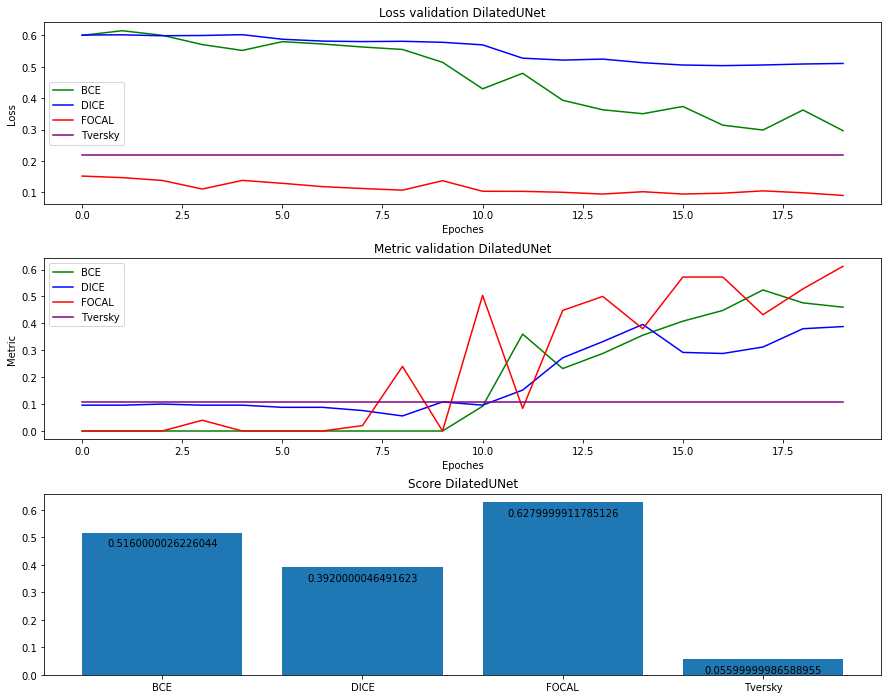

In [ ]:
scores = [dilated_bce_score, dilated_dice_score, dilated_focal_score, dilated_tversky_score]
plt.subplot(3, 1, 1)
plt.title('Loss validation DilatedUNet')
plt.ylabel('Loss')
plt.xlabel('Epoches')
plt.plot(torch.FloatTensor(dilated_bce_losses), color = "green", label='BCE')
plt.plot(torch.FloatTensor(dilated_dice_losses), color = "blue", label='DICE')
plt.plot(torch.FloatTensor(dilated_focal_losses), color = "red", label='FOCAL')
plt.plot(torch.FloatTensor(dilated_tversky_losses), color = "purple", label='Tversky')
plt.legend()
plt.subplot(3, 1, 2)
plt.title('Metric validation DilatedUNet')
plt.ylabel('Metric')
plt.xlabel('Epoches')
plt.plot(torch.FloatTensor(dilated_bce_metrics), color = "green", label='BCE')
plt.plot(torch.FloatTensor(dilated_dice_metrics), color = "blue", label='DICE')
plt.plot(torch.FloatTensor(dilated_focal_metrics), color = "red", label='FOCAL')
plt.plot(torch.FloatTensor(dilated_tversky_metrics), color = "purple", label='Tversky')
plt.legend()
plt.subplot(3, 1, 3)
plt.title('Score DilatedUNet')
plt.bar(['BCE', 'DICE', 'FOCAL', 'Tversky'],scores)
plt.subplots_adjust(wspace=10, hspace=0.3)
for i in range(4):
  plt.text(i, scores[i]-0.05, str(scores[i]), ha='center')

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 32, (3,3), padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.pool0 = nn.MaxPool2d(2)
        self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, (3,3), padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.pool1 =  nn.MaxPool2d(2)
        self.enc_conv2 = nn.Sequential(nn.Conv2d(64, 128, (3,3), padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, (3,3), padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.pool2 =  nn.MaxPool2d(2)
        self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, (3,3), padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, (3,3), padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        self.pool3 =  nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv0 = nn.Conv2d(256, 256, (3,3), padding=1, dilation=1);
        self.bottleneck_conv1 = nn.Conv2d(256, 256, (3,3), padding=2, dilation=2);
        self.bottleneck_conv2 = nn.Conv2d(256, 256, (3,3), padding=4, dilation=4);
        self.bottleneck_conv3 = nn.Conv2d(256, 256, (3,3), padding=8, dilation=8);
        self.bottleneck_conv4 = nn.Conv2d(256, 256, (3,3), padding=16, dilation=16);
        self.bottleneck_conv5 = nn.Conv2d(256, 256, (3,3), padding=32, dilation=32);

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(32)

        self.dec_conv0 = nn.Sequential(nn.Conv2d(512, 128, (3,3), padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, (3,3), padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.upsample1 = nn.UpsamplingBilinear2d(64)
        self.dec_conv1 = nn.Sequential(nn.Conv2d(256, 64, (3,3), padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, (3,3), padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.upsample2 = nn.UpsamplingBilinear2d(128)
        self.dec_conv2 = nn.Sequential(nn.Conv2d(128, 32, (3,3), padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.upsample3 = nn.UpsamplingBilinear2d(256)
        self.dec_conv3 = nn.Sequential(nn.Conv2d(64, 1, (3,3), padding=1),)
    def forward(self, x):
        # encoder
        c0 = self.enc_conv0(x)
        e0 = self.pool0(c0)
        c1 = self.enc_conv1(e0)
        e1 = self.pool1(c1)
        c2 = self.enc_conv2(e1)
        e2 = self.pool2(c2)
        c3 = self.enc_conv3(e2)
        e3 = self.pool3(c3)

        # bottleneck
        b0 = self.bottleneck_conv0(e3)
        b1 = self.bottleneck_conv1(b0)
        b2 = self.bottleneck_conv2(b1)
        b3 = self.bottleneck_conv3(b2)
        b4 = self.bottleneck_conv4(b3)
        b5 = self.bottleneck_conv5(b4)
        b = F.relu(b0 + b1 + b2 + b3 + b4 + b5)
        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), c3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), c2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), c1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), c0), dim=1))
        return d3

In [ ]:
from torchsummary import summary # чтобы смотреть описание модели и ее параметров как в keras

model = MyNet().to(device)
summary(model, input_size=(3, 256, 256), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

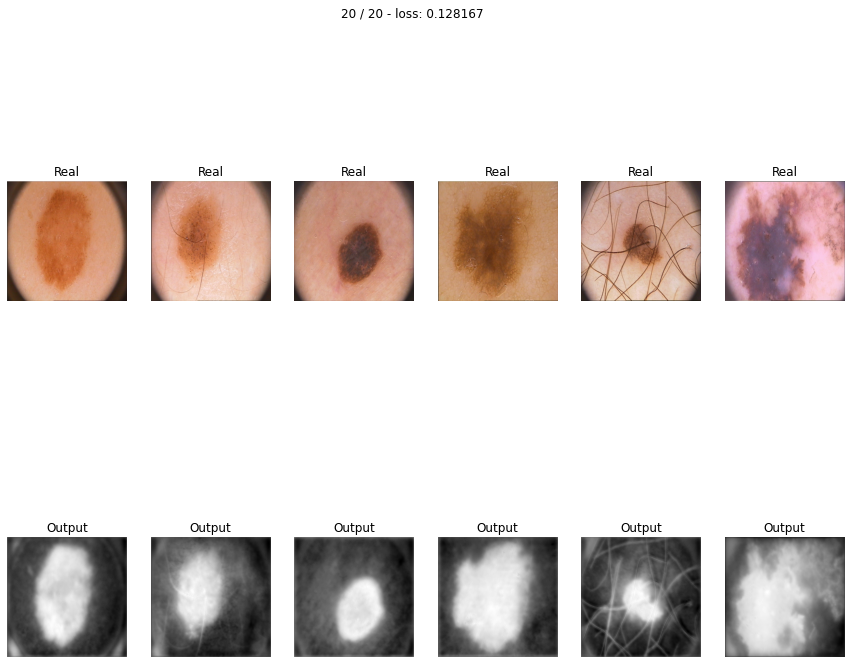

0.6580000221729279

In [ ]:
mynet = MyNet().to(device)
bce_losses, bce_metrics = train(mynet, torch.optim.Adam(mynet.parameters()), bce_loss, 20, data_tr, data_val) 
bce_score = score_model(mynet, iou_pytorch, data_ts)
bce_score

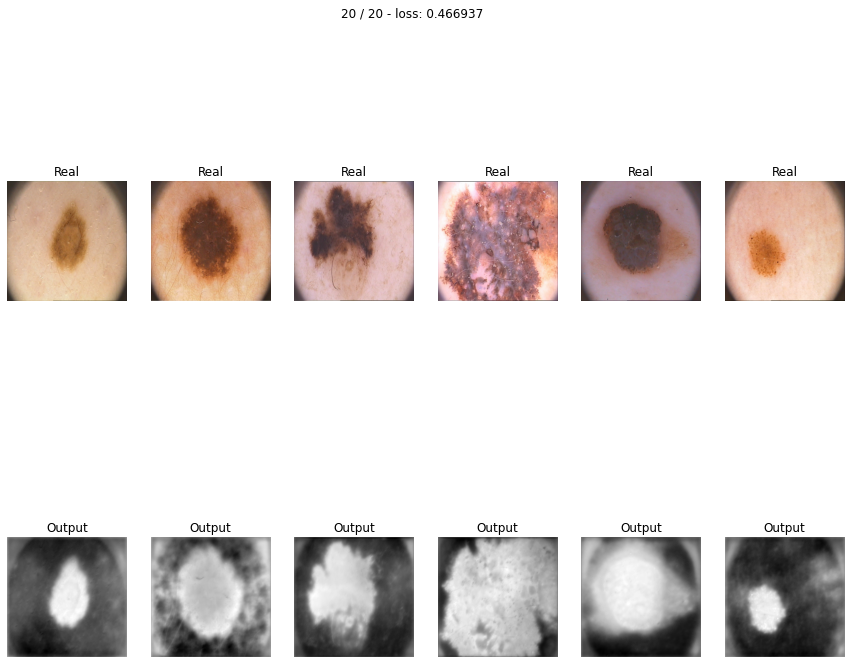

0.4179999828338623

In [ ]:
mynet = MyNet().to(device)
dice_losses, dice_metrics = train(mynet, torch.optim.Adam(mynet.parameters()), dice_loss, 20, data_tr, data_val) 
dice_score = score_model(mynet, iou_pytorch, data_ts)
dice_score

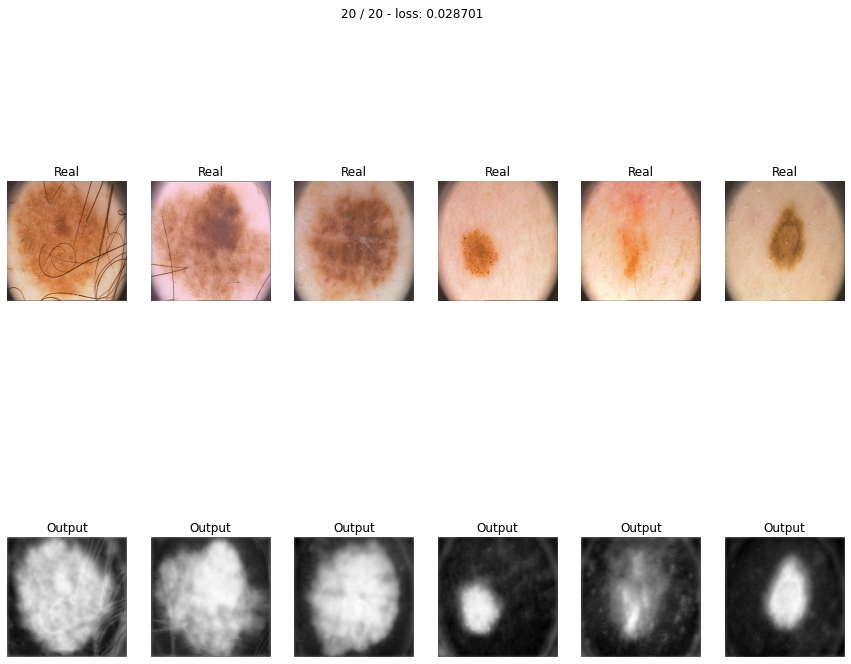

0.679999977350235

In [ ]:
mynet = MyNet().to(device)
focal_losses, focal_metrics = train(mynet, torch.optim.Adam(mynet.parameters()), focal_loss, 20, data_tr, data_val) 
focal_score = score_model(mynet, iou_pytorch, data_ts)
focal_score

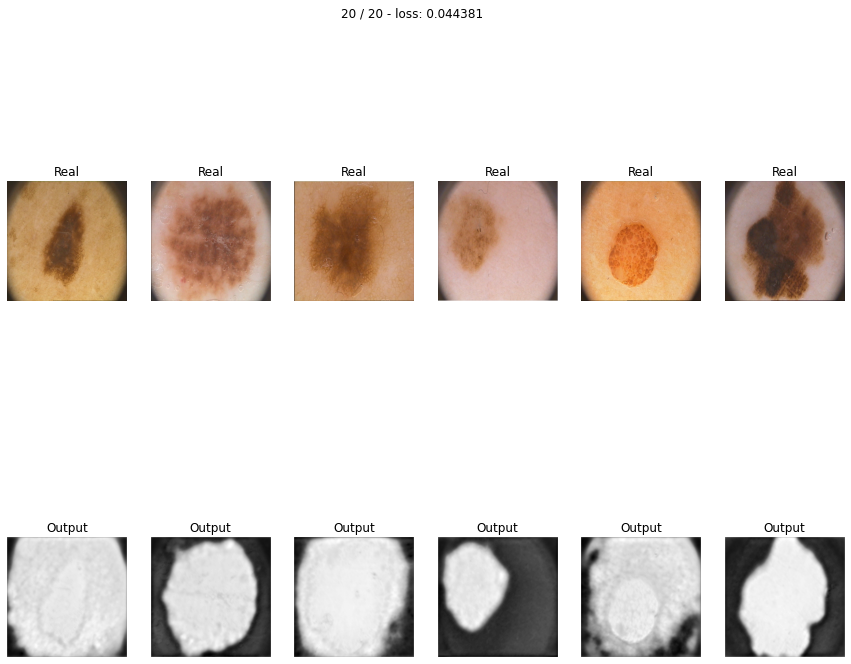

0.4880000054836273

In [ ]:
mynet = MyNet().to(device)
tversky_losses, tversky_metrics = train(mynet, torch.optim.Adam(mynet.parameters()), tversky_loss, 20, data_tr, data_val) 
tversky_score = score_model(mynet, iou_pytorch, data_val)
tversky_score

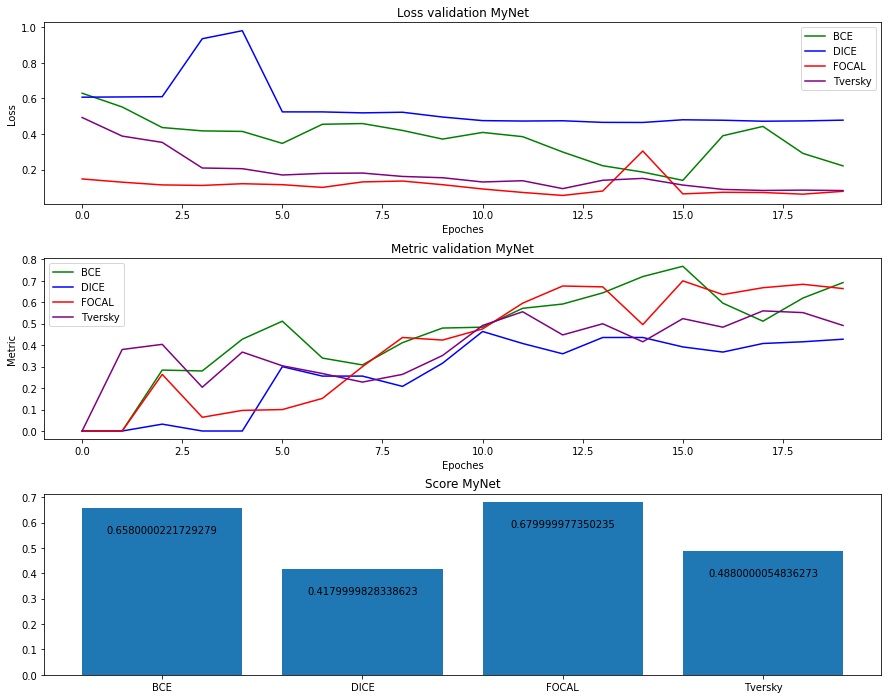

In [ ]:
scores = [bce_score, dice_score,focal_score, tversky_score]
plt.subplot(3, 1, 1)
plt.title('Loss validation MyNet')
plt.ylabel('Loss')
plt.xlabel('Epoches')
plt.plot(torch.FloatTensor(bce_losses), color = "green", label='BCE')
plt.plot(torch.FloatTensor(dice_losses), color = "blue", label='DICE')
plt.plot(torch.FloatTensor(focal_losses), color = "red", label='FOCAL')
plt.plot(torch.FloatTensor(tversky_losses), color = "purple", label='Tversky')
plt.legend()
plt.subplot(3, 1, 2)
plt.title('Metric validation MyNet')
plt.ylabel('Metric')
plt.xlabel('Epoches')
plt.plot(torch.FloatTensor(bce_metrics), color = "green", label='BCE')
plt.plot(torch.FloatTensor(dice_metrics), color = "blue", label='DICE')
plt.plot(torch.FloatTensor(focal_metrics), color = "red", label='FOCAL')
plt.plot(torch.FloatTensor(tversky_metrics), color = "purple", label='Tversky')
plt.legend()
plt.subplot(3, 1, 3)
plt.title('Score MyNet')
plt.bar(['BCE', 'DICE', 'FOCAL', 'Tversky'], scores)
plt.subplots_adjust(wspace=10, hspace=0.3)
for i in range(4):
  plt.text(i, scores[i]-0.1, str(scores[i]), ha='center')

Использование dilated convolutions имеет смысл, тк он улучшает качество из-за неучета всех пикселей в связи с пустотой между ячейками сверточного ядра, работая как dropout и давая новые признаки, тк "видит" по другому. Использование convolutions вместо pooling и upsampling тоже приводит к ухудшению, тк pooling помимо уменьшения размерности, дает инвариантность к смещению. 
Судя по проведенной работе, лучшие результаты показала функция BCE. Для своей архитектуры взял лучшее из всех предыдущих - maxpooling, upsampling, dilated conv и добавил слои.   